In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/bidirectional_dropout.h5'
modeloSave='/transfer_bidirectional_dropout_balanceado.h5'

In [5]:
balanceo='_down_equals'

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

In [7]:
paciente='paciente1'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

237

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

237

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

51

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

51

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

191

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

191

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

6/6 [==============================] - 1s 10ms/step


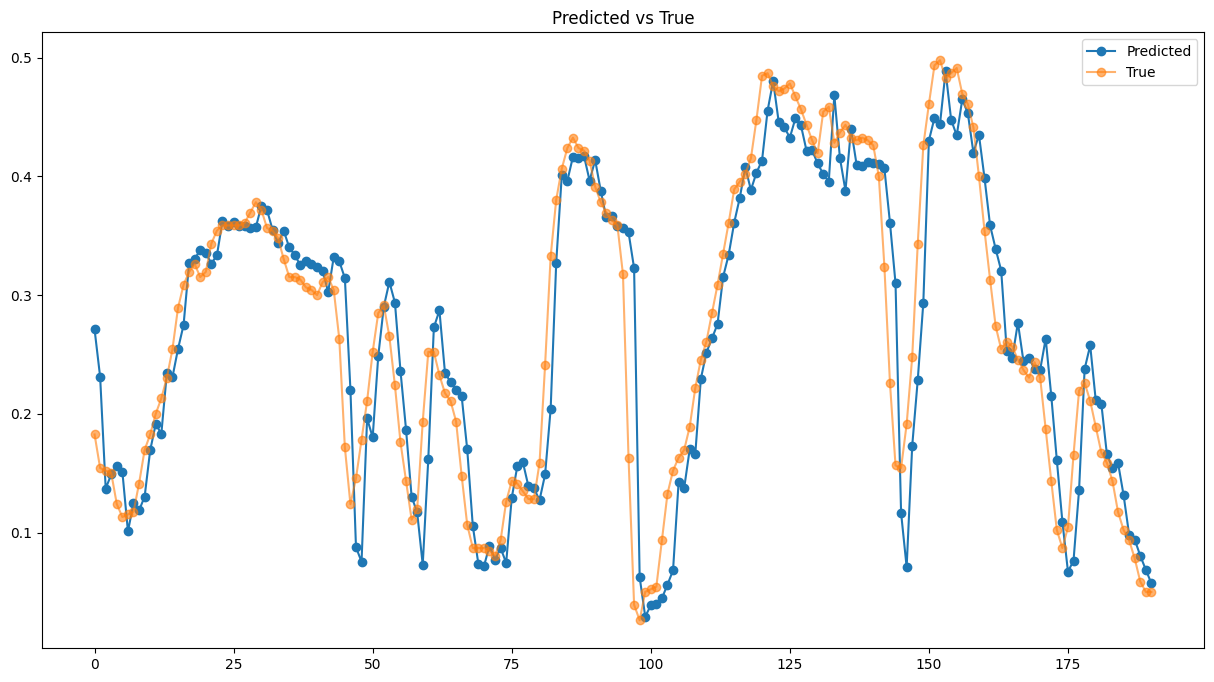

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03516492638851445,
 'mse': 0.051523845400699056,
 'rmse': 0.0026547066448751374}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                      

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_8')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-3,False,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_input (InputL  [(None, 30, 5)]          0         
 ayer)                                                           
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080  

In [27]:
array_Xtrain.shape

(237, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
8/8 [==============================] - 4s 123ms/step - loss: 0.0758 - mae: 0.2007 - mse: 0.0758 - val_loss: 0.0455 - val_mae: 0.1725 - val_mse: 0.0455
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0368 - mae: 0.1561 - mse: 0.0368 - val_loss: 0.0227 - val_mae: 0.1302 - val_mse: 0.0227
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0160 - mae: 0.1091 - mse: 0.0160 - val_loss: 0.0095 - val_mae: 0.0813 - val_mse: 0.0095
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.0057 - mae: 0.0615 - mse: 0.0057 - val_loss: 0.0050 - val_mae: 0.0522 - val_mse: 0.0050
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0044 - mae: 0.0490 - mse: 0.0044 - val_loss: 0.0045 - val_mae: 0.0482 - val_mse: 0.0045
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.0049 - mae: 0.0502 - mse: 0.0049 - val_loss: 0.0041 - val_mae: 0.0462 - val_mse: 0.0041
Epoch 7/100
8/8 [==========

6/6 [==============================] - 0s 10ms/step - loss: 0.0032 - mae: 0.0405 - mse: 0.0032
test loss, test acc: [0.0031589260324835777, 0.04051383584737778, 0.0031589260324835777]


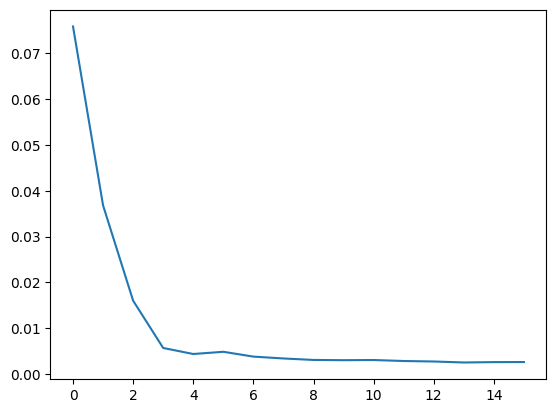

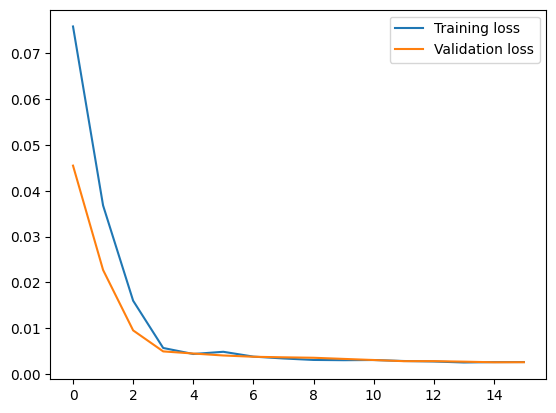

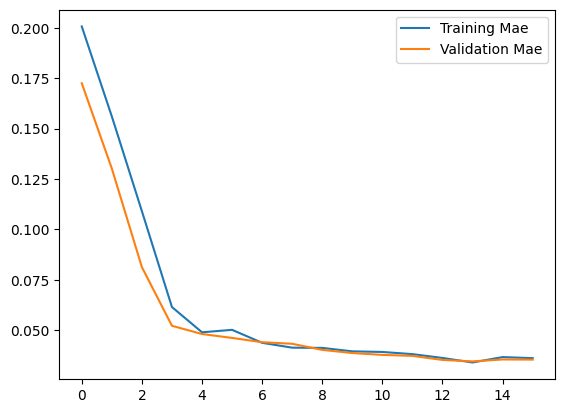

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

6/6 [==============================] - 1s 10ms/step


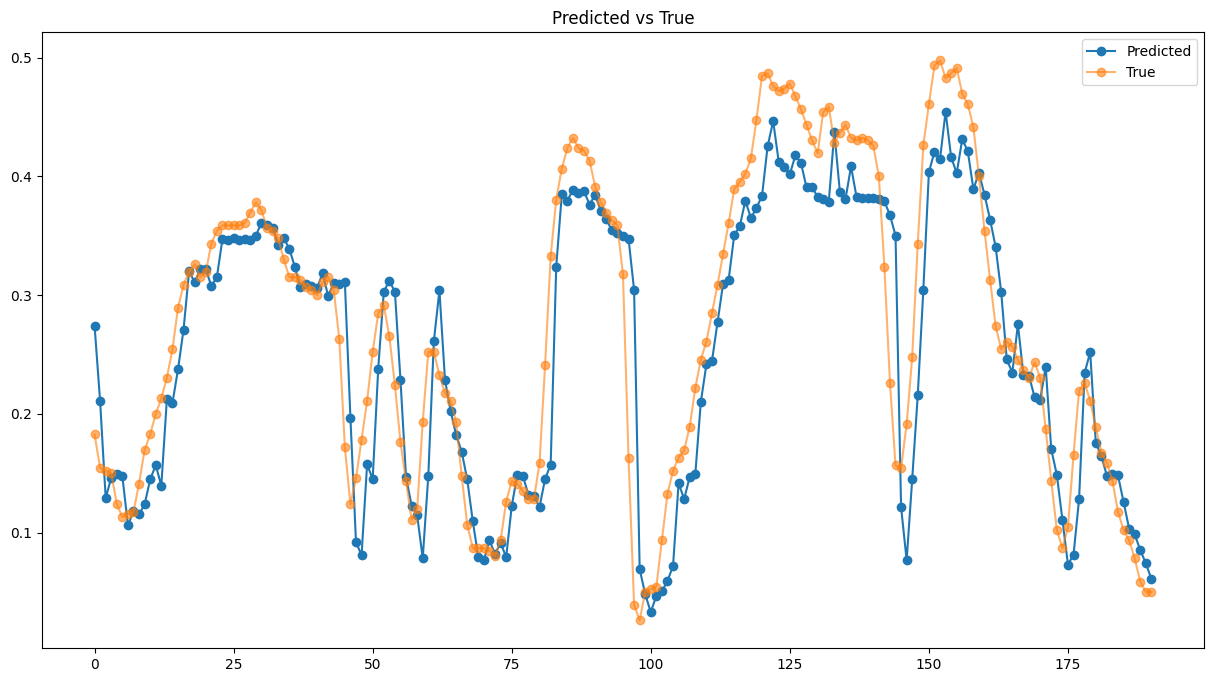

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.04051383544186131,
 'mse': 0.056204321137158245,
 'rmse': 0.0031589257144888127}

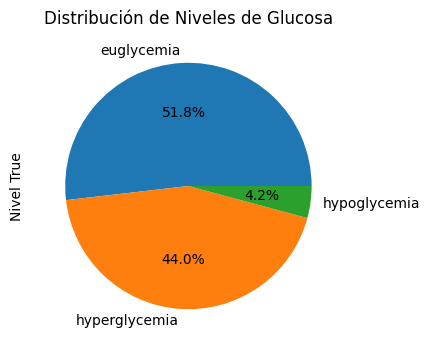

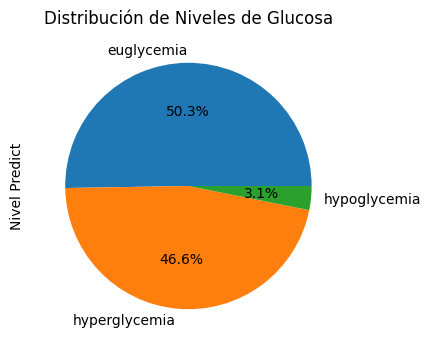

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,124.0,euglycemia,166.160721,euglycemia
1,111.0,euglycemia,136.809616,euglycemia
2,110.0,euglycemia,99.330887,euglycemia
3,109.0,euglycemia,107.295326,euglycemia
4,97.0,euglycemia,108.694260,euglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


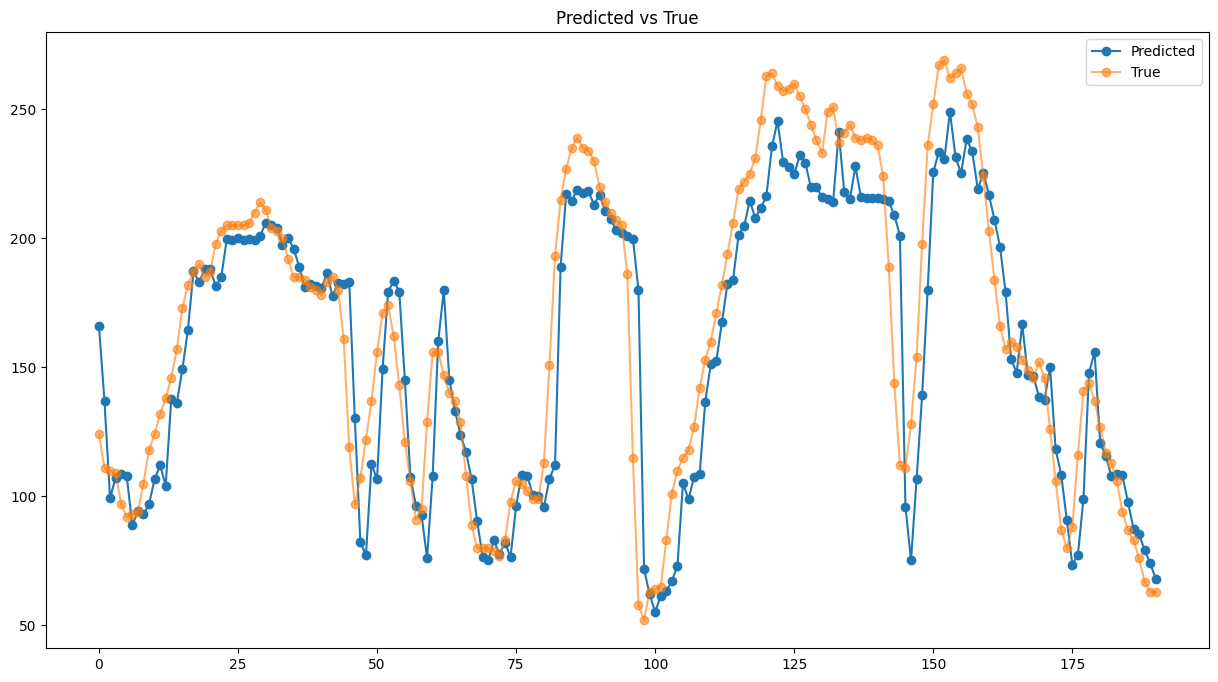

{'mae': 18.636364202848902,
 'mse': 25.853988375353612,
 'rmse': 668.4287149129198}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,124.0,166.160721
2023-01-01 00:15:00,111.0,136.809616
2023-01-01 00:30:00,110.0,99.330887
2023-01-01 00:45:00,109.0,107.295326
2023-01-01 01:00:00,97.0,108.694260
...,...,...
2023-01-02 22:30:00,83.0,87.532089
2023-01-02 22:45:00,76.0,85.336250
2023-01-02 23:00:00,67.0,79.169701
2023-01-02 23:15:00,63.0,74.082985


AP, BE, EP: (0.9157894736842105, 0.06315789473684211, 0.021052631578947368)


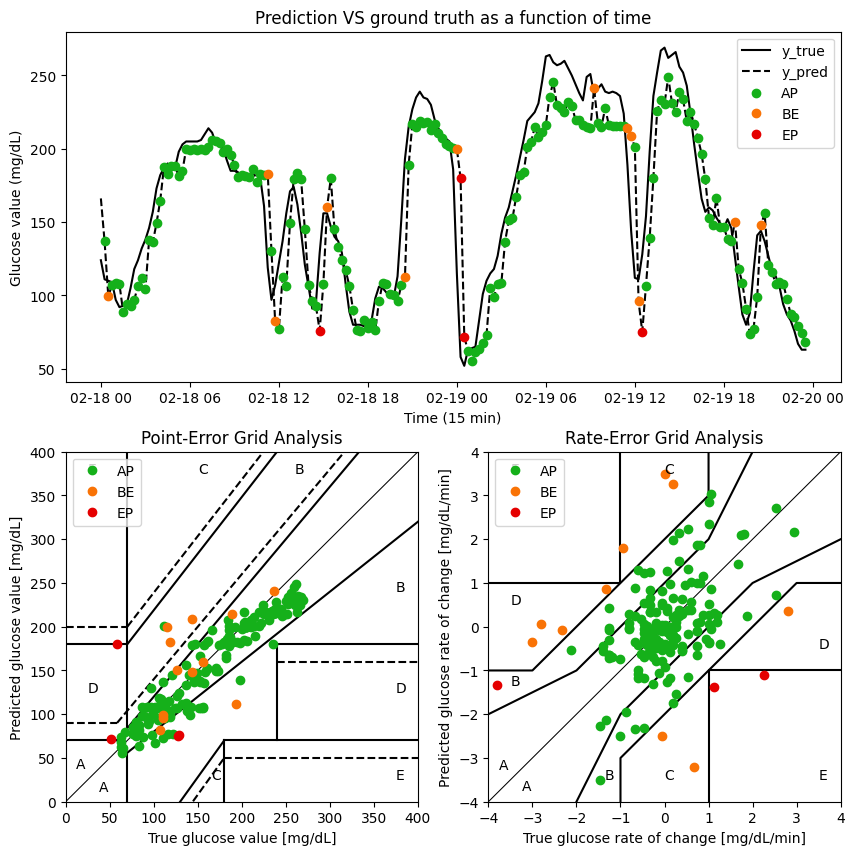

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)